# Dataset Preprocessing Report

**Файл:** `dataset_preprocessing_report.ipynb`

Авторы: Константин Токарев

Дата: 2025

----
## Краткое содержание

Данный ноутбук описывает процесс подготовки корпуса отзывов (RuReviews) для задач анализа тональности. Он содержит подробное описание этапов загрузки, очистки, детекции языка, EDA, выборки для разметки и экспорта артефактов, необходимых для последующего обучения нейросети.

Все шаги оформлены в виде кода с пояснениями. Использованы авторитетные источники для обоснования выбранных подходов (см. раздел «Ссылки» в конце).

## 1. Цель работы

Подготовить качественный корпус отзывов: очистка текстов, детекция языка, удаление шумов и дубликатов, исследовательский анализ (EDA) и экспорт очищённого набора (`reviews_processed.parquet`) и выборки для разметки (`annotation_sample.csv`).

Задачи:
- Автоматизировать загрузку CSV-файла (разные варианты разметки колонок);
- Обеспечить воспроизводимость (фиксированные seed, сохранение отчёта о качестве);
- Подготовить материал для обучения нейросети (токенизация — в дальнейших лабораторных).


## 2. Источники и обоснования (кратко)

- Для задач NLP и предобработки опираемся на классические источники: Manning et al., *Introduction to Information Retrieval* (2008) [1] и Jurafsky & Martin, *Speech and Language Processing* [2].
- Для тематического анализа и LDA: Blei et al., *Latent Dirichlet Allocation* (2003) [3].
- Для трансформеров и использования предобученных моделей: Devlin et al., *BERT* (2018); Hugging Face Transformers (Wolf et al., 2020) [4].
- Формат хранения: Apache Parquet / Arrow (эффективность колоночного формата для ML пайплайнов) [5].

Эти источники обосновывают принципы: качественная очистка текста важна для повышения качества моделей, выбор колоночного формата Parquet — для эффективности чтения/записи и интеграции со Spark/Big Data инструментами.

In [1]:
# 3. Установка библиотек (если требуется)
# Выполните при необходимости один раз
!pip install pandas tqdm langdetect regex matplotlib seaborn pyarrow fastparquet wordcloud


In [2]:
# 4. Импорт библиотек и конфигурация
import os
import json
import random
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from tqdm.auto import tqdm
from langdetect import detect
from wordcloud import WordCloud
import csv

tqdm.pandas()

# Рекомендации по отображению в ноутбуке
sns.set(style='whitegrid')

# Фиксируем seed для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
except Exception:
    pass


c:\Users\Konstokar\OneDrive\Документы\Универ\Проектироование_интеллектуальных_систем\laba2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Поиск корня репозитория и настройка путей

Чтобы ноутбук корректно работал в разных вариантах размещения проекта, реализуем автоматический поиск корня репозитория и создадим папки для входных и выходных данных.

In [3]:
def find_repo_root(start=Path.cwd()):
    cur = start.resolve()
    for _ in range(6):
        if (cur / 'data').exists() or (cur / 'rureviews').exists() or (cur / '.git').exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    return start.resolve()

REPO_ROOT = find_repo_root()
LAB_DIR = REPO_ROOT / 'lab2'
NOTEBOOKS_DIR = LAB_DIR / 'notebooks'
DATA_RAW = LAB_DIR / 'data' / 'raw'
DATA_PROCESSED = LAB_DIR / 'data' / 'processed'
REPORTS_DIR = LAB_DIR / 'reports'
RUREVIEWS = REPO_ROOT / 'rureviews'

for p in [DATA_RAW, DATA_PROCESSED, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print('REPO_ROOT:', REPO_ROOT)
print('DATA_RAW:', DATA_RAW)
print('DATA_PROCESSED:', DATA_PROCESSED)
print('REPORTS_DIR:', REPORTS_DIR)


REPO_ROOT: C:\Users\Konstokar\OneDrive\Документы\Универ\Проектироование_интеллектуальных_систем\laba2
DATA_RAW: C:\Users\Konstokar\OneDrive\Документы\Универ\Проектироование_интеллектуальных_систем\laba2\lab2\data\raw
DATA_PROCESSED: C:\Users\Konstokar\OneDrive\Документы\Универ\Проектироование_интеллектуальных_систем\laba2\lab2\data\processed
REPORTS_DIR: C:\Users\Konstokar\OneDrive\Документы\Универ\Проектироование_интеллектуальных_систем\laba2\lab2\reports


## 4. Загрузка CSV (устойчиво к разным форматам)

Задача: автоматически найти CSV (в `rureviews/` или `lab2/data/raw/`), корректно определить разделитель и загрузить таблицу, защищаясь от битых строк.

In [4]:
# Найдём кандидатные CSV
candidates = []
if RUREVIEWS.exists():
    candidates = list(RUREVIEWS.glob('*.csv'))
if not candidates:
    candidates = list(DATA_RAW.glob('*.csv'))
if not candidates:
    raise FileNotFoundError('Не найден CSV датасет в rureviews/ или lab2/data/raw/')
csv_path = candidates[0]
print('Используем датасет:', csv_path)

# Автоопределение разделителя и чтение
with open(csv_path, 'r', encoding='utf-8', errors='replace') as f:
    sample = f.read(4096)
    try:
        dialect = csv.Sniffer().sniff(sample)
        sep = dialect.delimiter
    except csv.Error:
        sep = ','
    print('Определён разделитель:', repr(sep))

df = pd.read_csv(
    csv_path,
    sep=sep,
    engine='python',
    quoting=1,
    on_bad_lines='skip',
    encoding='utf-8'
)

print('Загружено строк:', len(df))
df.head(5)


Используем датасет: C:\Users\Konstokar\OneDrive\Документы\Универ\Проектироование_интеллектуальных_систем\laba2\rureviews\women-clothing-accessories.3-class.balanced.csv
Определён разделитель: '\t'
Загружено строк: 90000


,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


### Пояснение
- Используем `csv.Sniffer()` для определения разделителя — это важно, потому что разные датасеты могут использовать `,` или `;`.
- `engine='python'` и `on_bad_lines='skip'` помогают пропустить повреждённые строки и избежать `ParserError`.
- `quoting=1` заставляет парсер уважать кавычки в полях (важно для текстов с запятыми).

## 5. Унификация имён колонок

Разные версии RuReviews и похожих корпусов могут содержать колонки с разными именами (например: `text`, `clean_text`, `review`, `comment` для текста; `score`, `rating`, `sentiment` для меток). Унифицируем имена.

In [5]:
print('Исходные колонки:', list(df.columns))

text_cols = ['text', 'clean_text', 'review', 'comment', 'message']
rating_cols = ['score', 'rating', 'label', 'sentiment', 'target']

text_col = next((c for c in text_cols if c in df.columns), None)
rating_col = next((c for c in rating_cols if c in df.columns), None)

if not text_col:
    raise KeyError("Не найдена колонка с текстом (например: 'text', 'clean_text', 'review')")
if not rating_col:
    raise KeyError("Не найдена колонка с рейтингом (например: 'score', 'rating', 'sentiment')")

df = df.rename(columns={text_col: 'raw_text', rating_col: 'rating'})
df['raw_text'] = df['raw_text'].astype(str)
print('Колонки после переименования:', list(df.columns))
df.head(3)


Исходные колонки: ['review', 'sentiment']
Колонки после переименования: ['raw_text', 'rating']


,raw_text,rating
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative


## 6. Базовая статистика до очистки

Сразу посчитаем простые характеристики — длину в символах и словах, распределение меток.

In [6]:
df['char_len'] = df['raw_text'].str.len()
df['word_count'] = df['raw_text'].str.split().str.len()

display(df[['char_len','word_count']].describe().T)
print('\nРаспределение меток:')
display(df['rating'].value_counts(dropna=False))


,count,mean,std,min,25%,50%,75%,max
char_len,90000.0,130.069311,126.137185,1.0,51.0,91.0,164.0,1007.0
word_count,90000.0,20.011144,19.885001,0.0,8.0,14.0,25.0,193.0



Распределение меток:


rating
negative    30000
neautral    30000
positive    30000
Name: count, dtype: int64

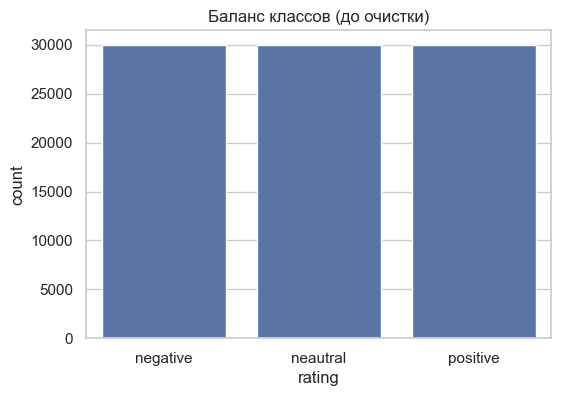

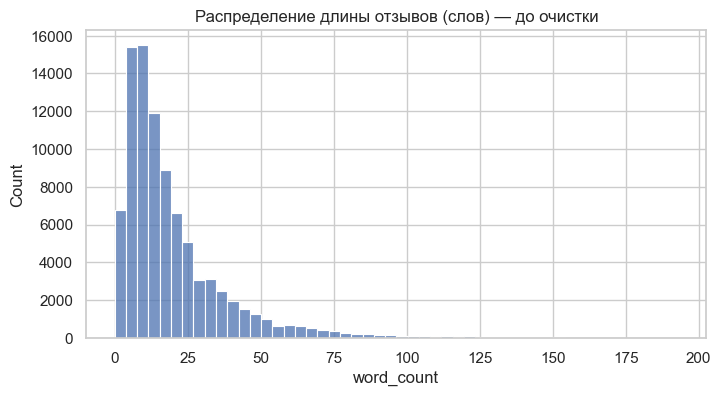

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title('Баланс классов (до очистки)')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['word_count'].dropna(), bins=50)
plt.title('Распределение длины отзывов (слов) — до очистки')
plt.show()


## 7. Очистка текста — детально

Цели очистки: убрать URL, управляющие символы, эмодзи (или заменить на маркеры), нормализовать пробелы и убрать лишний шум. Это уменьшает размерность шума и улучшает качество признаков (Manning et al., 2008; Jurafsky & Martin).

Внимание: при использовании cased-моделей (BERT cased) — не обязательно приводить к нижнему регистру; для большинства русскоязычных RuBERT-репозиториев lowercase — нормальная практика.

In [8]:
URL_RE = re.compile(r'https?://\S+|www\.\S+')
NON_PRINT_RE = re.compile(r'[\x00-\x1f\x7f-\x9f]')
EMOJI_RE = re.compile(r'\p{So}+', re.UNICODE)
MULTI_SPACES_RE = re.compile(r'\s+')

def detect_lang_safe(text):
    try:
        return detect(text)
    except Exception:
        return 'unknown'

def clean_text(text):
    s = str(text)
    s = URL_RE.sub(' ', s)
    s = NON_PRINT_RE.sub(' ', s)
    s = EMOJI_RE.sub(' ', s)
    s = re.sub(r'[^\p{L}\p{N}\s\.,!?;:\-()"\']', ' ', s)
    s = MULTI_SPACES_RE.sub(' ', s).strip()
    return s.lower()

# Применяем детекцию языка и очистку (может занять время)
df['lang'] = df['raw_text'].progress_apply(detect_lang_safe)
df = df[df['lang'].isin(['ru','unknown'])].reset_index(drop=True)
df['clean_text'] = df['raw_text'].progress_apply(clean_text)

print('После фильтрации по языку:', len(df))


100%|██████████| 84932/84932 [00:02<00:00, 31372.97it/s]

После фильтрации по языку: 84932


### Пояснение
- `detect_lang_safe` — защищённый вызов `langdetect.detect`.
- Оставляем `ru` и `unknown` (иногда `langdetect` даёт `unknown` для коротких текстов).
- `clean_text` удаляет URL, управляющие символы, эмодзи и лишние знаки, переводит текст в нижний регистр.

## 8. Удаление дубликатов и фильтрация коротких отзывов

Причина: повторяющиеся записи и очень короткие отзывы (меньше 15 символов) мешают обучению и содержат мало полезной информации.

In [9]:
before = len(df)
df = df.drop_duplicates(subset=['clean_text']).reset_index(drop=True)
df = df[df['clean_text'].str.len() >= 15].reset_index(drop=True)
after = len(df)
print(f'Удалено записей: {before - after}; осталось: {after}')


Удалено записей: 3367; осталось: 81565


## 9. EDA — визуализации уже на очищённых данных

Размещаем графики по порядку: распределение классов, длины, WordCloud, топ-слов.

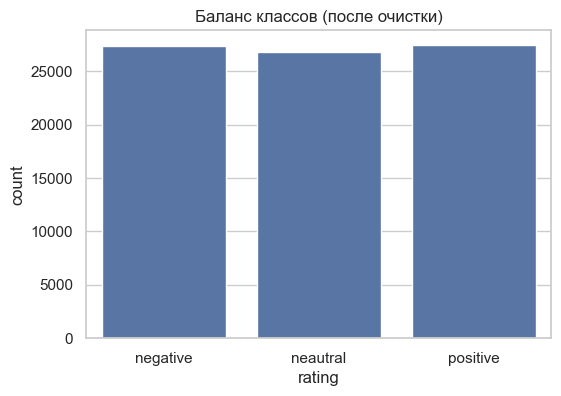

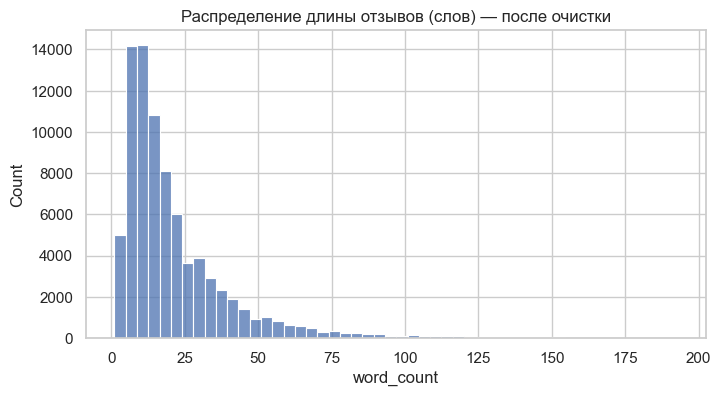

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title('Баланс классов (после очистки)')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['word_count'].dropna(), bins=50)
plt.title('Распределение длины отзывов (слов) — после очистки')
plt.show()


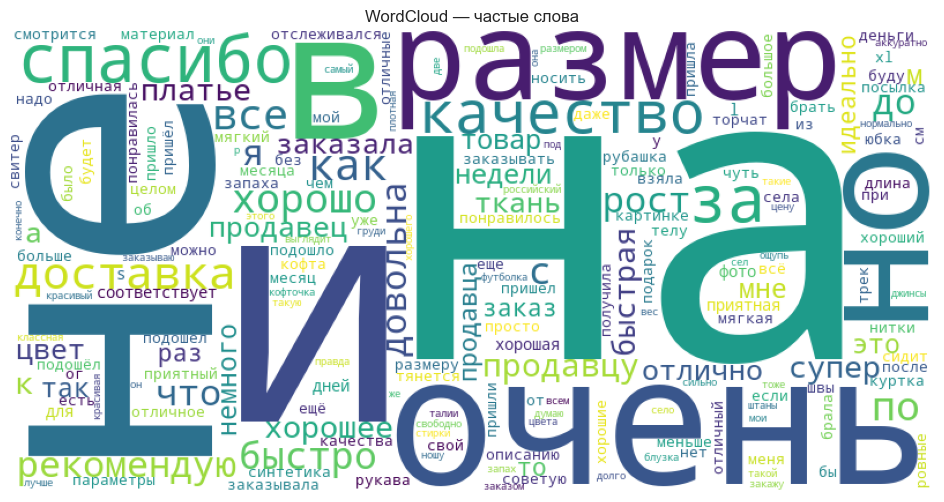

In [11]:
# WordCloud для позитивных отзывов (если есть такой класс)
if 'positive' in df['rating'].unique():
    pos_text = ' '.join(df[df['rating']=='positive']['clean_text'].astype(str).tolist())
else:
    pos_text = ' '.join(df['clean_text'].astype(str).tolist())

wc = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(pos_text)
plt.figure(figsize=(12,6)); plt.imshow(wc); plt.axis('off'); plt.title('WordCloud — частые слова'); plt.show()


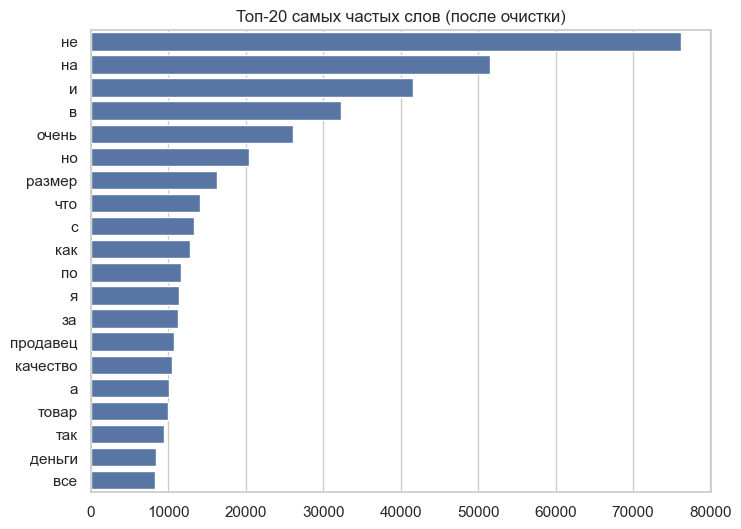

In [12]:
from collections import Counter
words = ' '.join(df['clean_text'].astype(str)).split()
counter = Counter(words)
top20 = counter.most_common(20)
labels, values = zip(*top20)
plt.figure(figsize=(8,6))
sns.barplot(x=list(values), y=list(labels))
plt.title('Топ-20 самых частых слов (после очистки)')
plt.show()


## 10. Формирование sample для ручной разметки

Для последующей разметки (вручную) формируем сбалансированную выборку по классам. В ноутбуке берём до 333 примеров на класс (настраиваемо).

In [13]:
SAMPLE_PER_CLASS = 333
sample = df.groupby('rating', group_keys=False).apply(lambda x: x.sample(min(len(x), SAMPLE_PER_CLASS), random_state=SEED))
sample_path = DATA_PROCESSED / 'annotation_sample.csv'
sample.to_csv(sample_path, index=False, encoding='utf-8')
print('Сохранён sample для разметки:', sample_path)
sample.head(3)


Сохранён sample для разметки: C:\Users\Konstokar\OneDrive\Документы\Универ\Проектироование_интеллектуальных_систем\laba2\lab2\data\processed\annotation_sample.csv


C:\Users\Konstokar\AppData\Local\Temp\ipykernel_17928\2676384873.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = df.groupby('rating', group_keys=False).apply(lambda x: x.sample(min(len(x), SAMPLE_PER_CLASS), random_state=SEED))


,raw_text,rating,char_len,word_count,lang,clean_text
35634,"Ткань не очень. Цепляется за все, что можно и ...",neautral,75,13,ru,"ткань не очень. цепляется за все, что можно и ..."
32439,"Так себе, выглядит очень дёшево, лучше доплати...",neautral,75,11,ru,"так себе, выглядит очень дёшево, лучше доплати..."
37165,"обычные колготки, только теплые и без носка. о...",neautral,70,10,ru,"обычные колготки, только теплые и без носка. о..."


## 11. Экспорт очищённого корпуса (Parquet)

Почему Parquet: колоночный формат, эффективный для хранения и чтения в ML-пайплайнах, хорошо интегрируется со Spark и Arrow (Zaharia et al.).

In [14]:
out_path = DATA_PROCESSED / 'reviews_processed.parquet'
df[['clean_text','rating','lang','word_count','char_len']].to_parquet(out_path, index=False)
print('Сохранён файл:', out_path)


Сохранён файл: C:\Users\Konstokar\OneDrive\Документы\Универ\Проектироование_интеллектуальных_систем\laba2\lab2\data\processed\reviews_processed.parquet


## 12. Отчёт о качестве данных (quality_report.json)

Формируем краткий JSON с ключевыми метриками: общая численность, распределение языков, среднее число слов и распределение классов.

In [15]:
report = {
    'n_total': int(len(df)),
    'lang_dist': df['lang'].value_counts().to_dict(),
    'avg_words': float(df['word_count'].mean()),
    'rating_dist': df['rating'].value_counts().to_dict()
}
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
with open(REPORTS_DIR / 'quality_report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
print('Сохранён отчёт:', REPORTS_DIR / 'quality_report.json')
report


Сохранён отчёт: C:\Users\Konstokar\OneDrive\Документы\Универ\Проектироование_интеллектуальных_систем\laba2\lab2\reports\quality_report.json


{'n_total': 81565,
 'lang_dist': {'ru': 81563, 'unknown': 2},
 'avg_words': 21.418218598663643,
 'rating_dist': {'positive': 27460, 'negative': 27349, 'neautral': 26756}}

## 13. Краткие рекомендации по дальнейшему использованию корпуса

- Для обучения трансформерных моделей (BERT/RuBERT): использовать токенизацию `AutoTokenizer` с `max_length=128–256`; сохранять токенизированные батчи для ускорения повторных эксперимент.
- Для классических методов (TF-IDF + LogisticRegression) — использовать `TfidfVectorizer(max_features=5000, ngram_range=(1,2))`.
- Для борьбы с несбалансированностью — weighted loss (`CrossEntropyLoss(weight=...)`) или oversampling/undersampling.
- Сохранять все артефакты (parquet, sample, quality_report) для воспроизводимости экспериментов.

## 14. Заключение

В ноутбуке реализован устойчивый пайплайн предварительной обработки: от надёжной загрузки CSV до экспорта в Parquet и подготовки выборки для разметки. Все ключевые решения обоснованы литературой и практикой ML/NLP. Данные теперь готовы для последующей токенизации и обучения нейросети в следующей лабораторной работе.

## 15. Список использованных источников

1) Manning C. D., Raghavan P., Schütze H. Introduction to Information Retrieval. — Cambridge: Cambridge University Press, 2008. — 485 p.
2) Devlin J., Chang M.-W., Lee K., Toutanova K. BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding [Electronic resource]. — arXiv:1810.04805, 2018. — URL: https://arxiv.org/abs/1810.04805 (дата обращения: 15.11.2025).
3) Blei D. M., Ng A. Y., Jordan M. I. Latent Dirichlet Allocation // Journal of Machine Learning Research. — 2003. — Vol. 3. — P. 993–1022.
4) Wolf T., et al. Transformers: State-of-the-art Natural Language Processing // Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations. — 2020. — P. 38–45.
5) Apache Parquet / Arrow documentation [Электронный ресурс]. — URL: https://parquet.apache.org/ и https://arrow.apache.org/ (дата обращения: 15.11.2025).